# Goals / Plan

- Using regret for the game works, but is slow
    - choosing 1 random contract per round only, 1 random action per player
    - regret is inaccurance b/c it is based on a random sample from opponent's mixed strategies; imprecise

- How can we apply regret minimization WITHOUT random sampling (use precise probabilities)?

# Symmetric Regret and Convolutions

- example scenario:
    - contract is uniform [700, 1300]
    - contract is N(1000, 150) - bonus
    - 10 players for both

- initializations:
    - realistically, assume nobody is bidding over 200
    - initialize regret of options 1-200 np.zeros(200) --> even probabilities

- calculating regret:
    - assume we have a 200-length probability vector p
    - we want to find the regret of choosing each option based on MIXED STRATEGIES of opponents + CONTRACT PDF
        - this is the key, not using random samples, but exact probabilities

regret of choosing a value x:
- convolution of the other 9 players pdfs over values < x:
    - length x, convolve 9 times --> 9x log(9x)
    - this is the distribution of the sum of other players' lower bids
- how to integrate contract pdf
    - integral of [(contract == c) * (convolution cdf < c - x)]
    - don't calculate integral, do it discrete
    - for uniform distribution, calculate each contract value, then average (600 scenarios)

time complexity of calculating regret for value x:
- convolution takes 9x log (9x) time
- turn pdf into cdf (prefix sum linear time, 9x)
- for each contract scenario, find sum of probabilities (600 time)
- overall: 9x log(9x) * 600

time complexity over all values:
- Sum x=1 to x=200 of (9x log(9x) * 600) = 10^8 about
- Expressed differently: about max x^2 * players * contract length
- Assuming max x is about max(contract) / players * 2
- O(max(contract)^2 * contract length)

change to contract is [350, 650], 10 players (still feels like enough granularity)
- now instead of 10^8, about 10^7 per iteration
- iterations converge much quicker, about 100 iterations maybe?

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import time
COLORS = sns.color_palette("pastel")

In [23]:
""" 
Variables to define:
    provide own reward function (given the single mixed strategy, # other players) --> calculate the reward
    support space
    number of players
"""
class SymmetricRegret:
    def __init__(self, num_players, support, contractFunction):
        self.PLAYERS = num_players
        self.ACTIONS = support
        self.contractFunction = contractFunction

        self.regret = np.zeros(len(support))
        self.last_regret = np.zeros(len(support))
    
    def convolve_pdf_n_times(self, p, n):
        p = np.array(p, dtype=np.float64)
        p[0] = 1 - np.sum(p[1:]) if np.sum(p) < 1 else p[0]

        M = len(p)
        out_len = n * (M - 1) + 1
        
        fft_len = 2**int(np.ceil(np.log2(out_len)))

        p_padded = np.zeros(fft_len, dtype=np.float64)
        p_padded[:M] = p

        Pn = np.fft.fft(p_padded) ** n
        conv_n = np.fft.ifft(Pn).real
        return conv_n[:out_len]
    
    def regretFunction(self, actions, strategy, num_players, contract_distribution):
        assert len(actions) == len(strategy)
        rewards = np.zeros(len(actions))
        zero_padded_strategies = np.concatenate([np.zeros(min(actions)), strategy])

        for i, x in enumerate(actions):
            convolved = self.convolve_pdf_n_times(zero_padded_strategies[:x+1], num_players) # we always LOSE the ties
            convolved = np.cumsum(convolved)

            # find the reward
            probability = 0
            for contract_prob, contract_val in contract_distribution:
                value_threshold = contract_val - x # convolution needs to sum to <= value threshold, for us to get filled

                if value_threshold < 0: continue
                probability += contract_prob * (convolved[value_threshold] if value_threshold < len(convolved) else 1)

            # rewards
            rewards[i] = probability * x

        avg_reward = rewards * strategy
        regret = rewards - np.sum(avg_reward)
        return regret
    
    def get_strategy(self):
        ceiling = np.maximum(0, self.regret)
        if np.sum(ceiling) == 0: ceiling = np.ones(len(ceiling))
        strategy = ceiling / np.sum(ceiling)
        return strategy
    
    def solve(self, trials, verbose=None):
        for i in range(trials):
            strategy = self.get_strategy()

            current_regret = self.regretFunction(self.ACTIONS, strategy, self.PLAYERS - 1, self.contractFunction)
 
            new_regret = self.regret + current_regret
            # Prints and breaks
            if np.isclose(np.maximum(current_regret, 0), 0, atol=1e-3).all():
                print(f"Breaking at iteration {i}")
                break
            if verbose and (i%verbose == 0): print(new_regret)

            self.regret = new_regret
            self.last_regret = current_regret

    def output_strategy(self):
        nonzero_actions = []
        for action, probability in zip(self.ACTIONS, self.get_strategy()):
            tol = 1e-4
            if probability < tol: continue
            nonzero_actions.append((action, probability))
        print(nonzero_actions)

Breaking at iteration 16
Breaking at iteration 174


Text(0.5, 1.0, 'Dist. from 100 is 40')

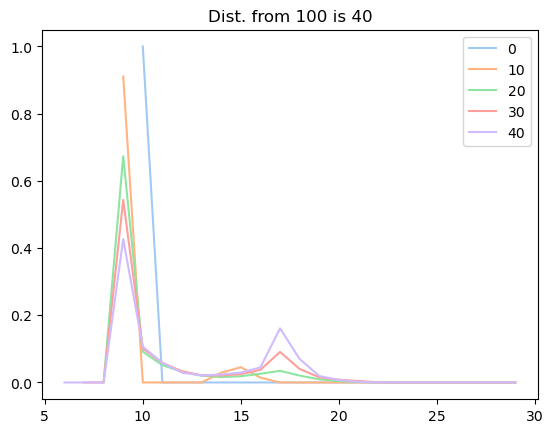

In [31]:
# Investigate how contract polarization affects Equilibrium
NUM_PLAYERS = 10
for i in range(5):
    lo, hi = 100 - i*10, 100 + i*10
    contract = [(0.5, lo), (0.5, hi)]
    ACTIONS = np.arange(lo//NUM_PLAYERS,30)

    r = SymmetricRegret(NUM_PLAYERS, ACTIONS, contract)
    r.solve(1000, verbose=None)
    strategy = r.get_strategy()

    sns.lineplot(x=ACTIONS, y=strategy, color=COLORS[i], label=i*10)

plt.title(f'Dist. from 100 is {i*10}')

In [ ]:
# Investigate how # players affects equilibrium

for players in [2,3,5,10,20]:
    NUM_PLAYERS = i
    contract = [(0.5, 5*players), (0.5,15*players)]
    ACTIONS = np.arange(lo//NUM_PLAYERS,30)

    r = SymmetricRegret(NUM_PLAYERS, ACTIONS, contract)
    r.solve(1000, verbose=None)
    strategy = r.get_strategy()

    sns.lineplot(x=ACTIONS, y=strategy, color=COLORS[i], label=i*10)

plt.title(f'Dist. from 100 is {i*10}')